In [1]:
#Useful imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, asin, acos, atan
%reload_ext autoreload
%autoreload 2
plt.style.use('latex')

## Load and visualize data

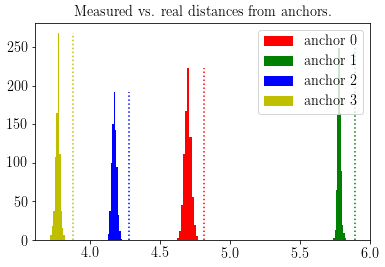

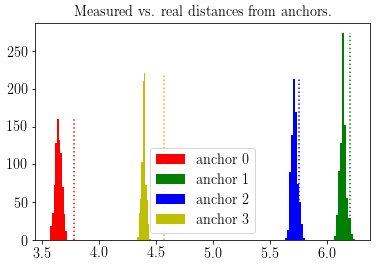

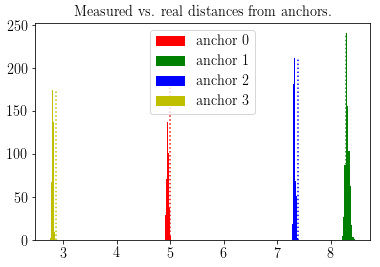

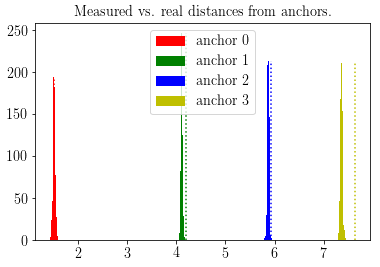

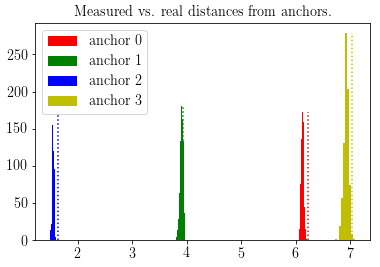

In [3]:
path = 'data/Static/'
anchors_full = np.genfromtxt(path+'anchors_EPFL.csv', delimiter=',')
anchors = anchors_full[:,1:]
real_full = np.genfromtxt(path+'data_EPFL.csv', delimiter=',')
real = real_full[:,1:]
n_positions = 5
N = anchors.shape[0]+1 

distances_all_points = []

colors = ['r','g','b','y','c']
for i in range(n_positions):
    data = np.genfromtxt(path+'pozyx_data_P{}.csv'.format(i), delimiter=',')
    P_i = real[i,:]
    id_i = int(real_full[i,0])
    
    idx_i = data[:,1] == id_i
    # Get samples corresponding to all pairs.
    distances_per_point  = []
    
    fig = plt.figure()
    #fig.set_fig(20)
    for j,a in enumerate(anchors_full):
        axs = fig.add_subplot(1,1,1)
        #axs = fig.add_subplot(1,len(anchors_full),j+1)
        P_a = a[1:]
        id_a = int(a[0])
        idx_a = data[:,2] == id_a 
        distance_real = np.linalg.norm(P_a - P_i)
        distances_ia = data[idx_a & idx_i, -1]
        distances_per_point.append(distances_ia)
        vals, bins, __ = axs.hist(distances_ia, label='anchor {}'.format(j),color=colors[j])
        ymax = max(vals)
        axs.vlines(distance_real, 0, ymax,color=colors[j], linestyle=':')
        plt.legend(loc='best')
    plt.title('Measured vs. real distances from anchors.')
    plt.show()
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #bp = ax.boxplot(distances_per_point)
    #ax.set_xlabel('Anchor Id')
    #ax.set_ylabel('Distance [m]')
    #ax.set_xticklabels(anchors_full[:,0].astype('int').astype('str'))
    #ax.set_title('Point {}: {}, id={}'.format(i,P_i,id_i))
    #plt.show()
    distances_all_points.append(distances_per_point)

## Apply algorithms

phi(-0.20237772464616605)=[[ 262.71908727]], phi(100000.0)=[[-12503.11089367]]
Noisy edm error 2.97423675465
SRLS edm error 1.90553206075
MDS edm error  1.38579437773


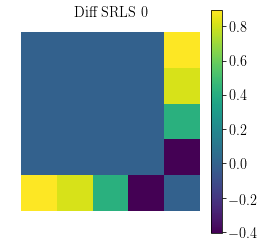

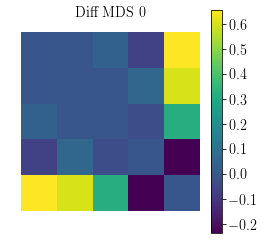

phi(-0.20237772464616605)=[[ 2586.10101666]], phi(100000.0)=[[-12507.07249588]]
Noisy edm error 2.93751625354
SRLS edm error 2.84291713156
MDS edm error  2.94840488551


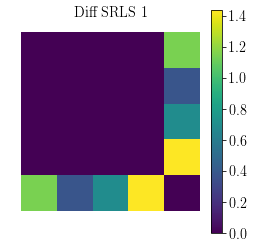

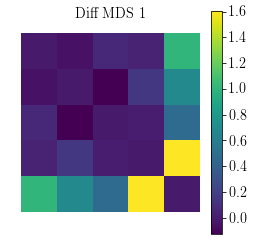

phi(-0.20237772464616605)=[[ 239.62901454]], phi(100000.0)=[[-12520.04927241]]
Noisy edm error 1.58841142208
SRLS edm error 1.56755491496
MDS edm error  1.58596887319


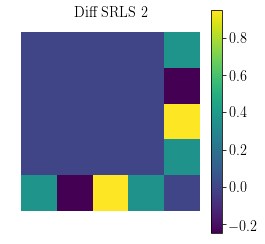

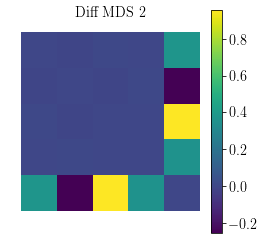

phi(-0.20237772464616605)=[[ 6218.32706956]], phi(100000.0)=[[-12508.27794508]]
Noisy edm error 5.9621264563
SRLS edm error 5.61279301839
MDS edm error  6.0975977101


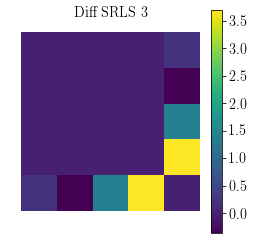

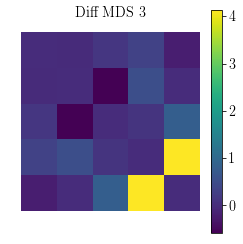

phi(-0.20237772464616605)=[[ 432.73134807]], phi(100000.0)=[[-12507.10836909]]
Noisy edm error 2.86139124474
SRLS edm error 2.86117032918
MDS edm error  2.85695356471


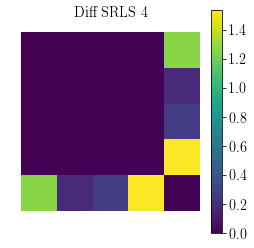

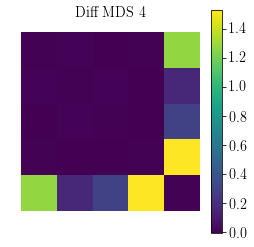

In [7]:
from point_configuration import HeterogenousConfiguration, PointConfiguration, dm_from_edm
from algorithms import reconstruct_mds, reconstruct_srls
    
d = 3
n_positions=5

points_mds = []
points_srls = []
points_original = []

printout=True

for i in range(n_positions):
    P_i = real[i,:]
    porig = HeterogenousConfiguration(anchors.shape[0]+1,d)
    porig.points = np.r_[anchors,P_i.reshape((1,-1))]
    index = porig.N-1
    porig.init()
    
    
    distances_per_point = distances_all_points[i]
    dist = [np.mean(d) for d in distances_per_point]
    r2 = np.power(dist,2)
    
    pnoisy = porig.copy()
    pnoisy.edm[:,index] = np.insert(r2, index, 0)
    pnoisy.edm[index,:] = np.insert(r2, index, 0)
    dm = dm_from_edm(pnoisy.edm) 
    
    Xmds = reconstruct_mds(dm, porig.points, False, 'geometric')
    Xsrls = reconstruct_srls(r2, porig.points, False)
    
    pmds = PointConfiguration(N, d)
    psrls = PointConfiguration(N, d)
    pmds.points = Xmds
    psrls.points = Xsrls
    pmds.init()
    psrls.init()
    if (printout):
        print('Noisy edm error',np.linalg.norm(pnoisy.edm-porig.edm))
        print('SRLS edm error',np.linalg.norm(psrls.edm-porig.edm))
        print('MDS edm error ',np.linalg.norm(pmds.edm-porig.edm))
        plt.matshow(porig.edm-psrls.edm)
        plt.colorbar()
        plt.axis('off')
        plt.title('Diff SRLS {}'.format(i))
        plt.show()
        plt.matshow(porig.edm-pmds.edm)
        plt.colorbar()
        plt.axis('off')
        plt.title('Diff MDS {}'.format(i))
        plt.show()
    
    points_original.append(porig.points)
    points_mds.append(Xmds)
    points_srls.append(Xsrls)

## 2D Visualization

rmse mds 0.17614402262738996
rmse srls 0.2028143304642516


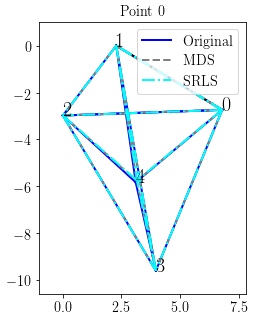

rmse mds 0.23170631379700118
rmse srls 0.2274568076708455


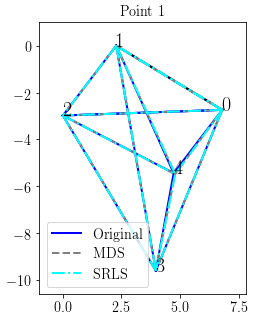

rmse mds 0.9263142348946207
rmse srls 0.9274260757824668


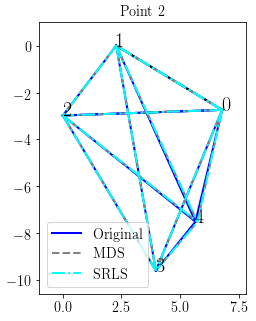

rmse mds 0.14182934087856824
rmse srls 0.15253881393851484


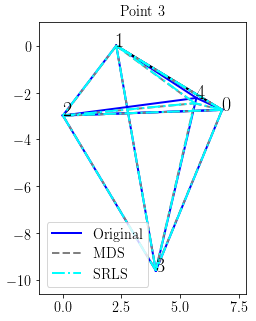

rmse mds 0.11496525859573857
rmse srls 0.11569177591510262


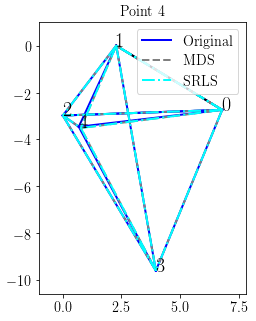

In [14]:
from plots import plot_point_sets
from basics import rmse

size = [5,5]
n_positions=5
for i in range(n_positions):
    Xorig = points_original[i]
    Xmds = points_mds[i]
    Xsrls = points_srls[i]
    rmse_mds = rmse(Xmds[-1,:], Xorig[-1,:])
    rmse_srls = rmse(Xsrls[-1,:], Xorig[-1,:])
    
    print('rmse mds', rmse_mds)
    print('rmse srls', rmse_srls)
    
    plot_point_sets([Xorig,Xmds,Xsrls],'Point {}'.format(i),size=size, names=('Original','MDS','SRLS'))
    #plot_points(Xsrls, title='SRLS, rmse={:2.2e}'.format(rmse_slrs), size=size)
    #plot_points(Xmds, title='MDS, rmse={:2.2e}'.format(rmse_mds),size=size)

## 3D Visualization

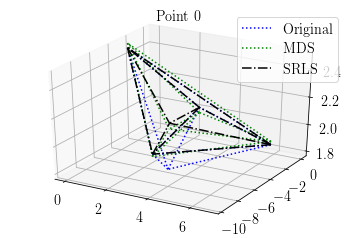

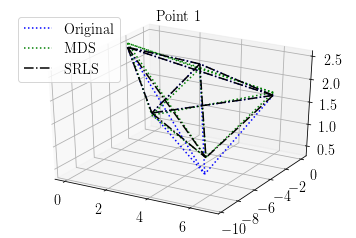

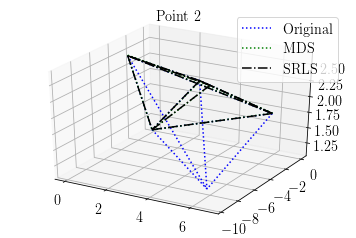

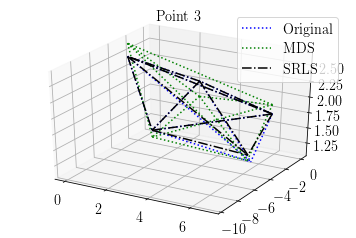

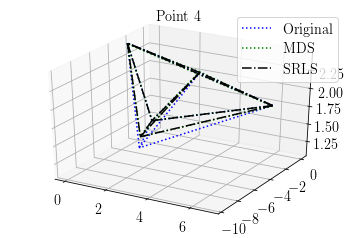

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import itertools

n_positions=5
for i in range(n_positions):
    Xorig = points_original[i]
    Xmds = points_mds[i]
    Xsrls = points_srls[i]
    plot_points = [Xorig, Xmds, Xsrls]
    cmap = ['b','g','k']
    linestyles = [':',':','-.']
    names = ['Original','MDS','SRLS']
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    for counter, X in enumerate(plot_points):
        first = True
        for pairs in itertools.combinations(range(N),2):
            x = X[pairs,0]
            y = X[pairs,1]
            z = X[pairs,2]
            if first:
                ax.plot(x, y, z, color=cmap[counter], linestyle=linestyles[counter],label=names[counter])
                first = False
            else:
                ax.plot(x, y, z, color=cmap[counter], linestyle=linestyles[counter])
    ax.set_title('Point {}'.format(i))
    ax.legend()
    plt.show()